## Интеллектуальный анализ данных – весна 2025
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать с усеченным датасетом `Palmer Penguins`, содержащим информацию о характеристиках трех видов пингвинов: `Adelie`, `Chinstrap` и `Gentoo`:



*   Species — вид пингвина (целевая переменная).
*   Island — остров, на котором была сделана запись.
*   Clutch Completion — завершенность кладки яиц.
*   Date Egg — закодированная дата откладки яиц (число дней от самой ранней даты в данных).
*   Culmen Length (mm) — длина клюва.
*   Culmen Depth (mm) — глубина клюва.
*   Flipper Length (mm) — длина ласт.
*   Body Mass (g) — масса тела в граммах.
*   Sex — пол особи.
*   Delta 15 N (o/oo) и Delta 13 C (o/oo) — изотопные значения, характеризующие пищевые предпочтения.

Описание полного набора данных и дополнительную информацию о проекте можно найти [здесь](https://allisonhorst.github.io/palmerpenguins/index.html) и [здесь](https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data?resource=download).

![Palmer Penguins](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)



In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
data = pd.read_csv('penguins_data.csv')
data.head(10)

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971
5,Gentoo,Biscoe,Yes,22,48.1,15.1,209.0,5500.0,MALE,8.45738,-26.22664
6,Gentoo,Biscoe,Yes,13,51.1,16.5,225.0,5250.0,MALE,8.20660,-26.36863
7,Gentoo,Biscoe,No,392,42.7,13.7,208.0,3950.0,FEMALE,8.14567,-26.59467
8,Adelie,Biscoe,Yes,14,39.6,20.7,191.0,3900.0,FEMALE,8.80967,-26.78958
9,Gentoo,Biscoe,Yes,735,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390


In [34]:
data.shape

(344, 11)

**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные признаки? Если да, то закодируйте их самым оптимальным способом. Аргументируйте свой выбор.

In [35]:
data.isna().sum()

Species                 0
Island                  0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      2
Culmen Depth (mm)       2
Flipper Length (mm)     2
Body Mass (g)           2
Sex                    10
Delta 15 N (o/oo)      14
Delta 13 C (o/oo)      13
dtype: int64

### Числовые:

У пары пингвинов нет данныых о размерах частях тел.

Также у большего числа пингвинов не удалось собрать данные о вкусовых предпочтениях.
Возможно, влияет пол и фактор выынашивания яиц (`Clutch Completion`)

### Категориальные:

Иногда в данных пропущен пол.

Сначала разберемся с категиальными данными, то есть
 расследуем гендер пингвинов.

Пороверим зависимость гендера от веса.

In [36]:
data["Sex"].value_counts()

Sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64

помимо пропусков, есть пингвин с точкой как гендером, его тоже недообследовали.

<Axes: ylabel='Body Mass (g)'>

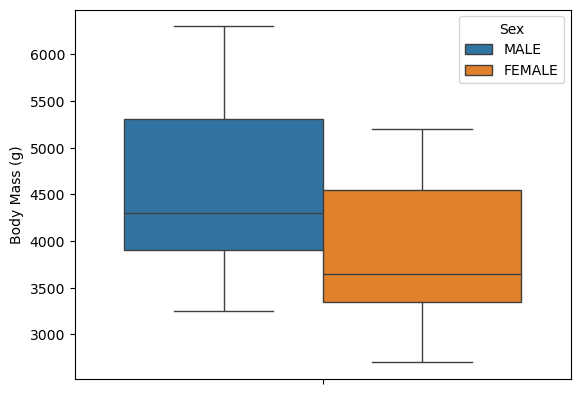

In [37]:
data_no_sex = (data["Sex"].isna()) | (data["Sex"] == ".")
data_with_sex = data[~data_no_sex]

sns.boxplot(
    data=data_with_sex,
    hue="Sex",
    y="Body Mass (g)",
)

Самцы в среднем тяжелее самок. Скажем, что в среднем самцы тяжелее 3750,
а самки - легче.

Далее проверим, значит ли то, что яйцо высиживают, что это делает самка.

Проверим, сколько пингвинов мы сможем правильно разделить, если поставим четкое разграничение в 3750

In [41]:
is_male = data_with_sex["Body Mass (g)"] < 3750

wrong_n = is_male.compare(data_with_sex["Sex"] == "FEMALE").shape[0]
1 - (wrong_n / is_male.shape[0])

0.7207207207207207

Таким образом, получили условие, которое пусть и не идеальное
(чуть более 70% угадываются верно), но это уже лучше, чем случайность.

Теперь вспомним, что у никоторых пингвинов отсутсвует и масса.
Посмотрим на данныее с отсутствующей массой 

In [42]:
data_no_mass = data[data["Body Mass (g)"].isna()]
data_no_mass

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
44,Adelie,Torgersen,Yes,746,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,Gentoo,Biscoe,No,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В этих данных больше половины данных потеряны, так что можем считать
потерю этих семплов несущесвенной. Удалим эти семплы.

In [43]:
data.drop(data_no_mass.index, inplace=True)

Проверим пропуски данных

In [44]:
data.isna().sum()

Species                 0
Island                  0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      0
Culmen Depth (mm)       0
Flipper Length (mm)     0
Body Mass (g)           0
Sex                     8
Delta 15 N (o/oo)      12
Delta 13 C (o/oo)      11
dtype: int64

Теперь восстановим в данных гендеры пингвинов, опираясь на их (пингвинов)
вес

In [45]:
data["Sex"].value_counts()

Sex
MALE      168
FEMALE    165
.           1
Name: count, dtype: int64

In [46]:
data.loc[data_no_sex & (data["Body Mass (g)"] < 3750), "Sex"] = "FEMALE"
data.loc[data_no_sex & (data["Body Mass (g)"] > 3750), "Sex"] = "MALE"

Проверим, что пропуски убраны и больше нет фальшивых значений!

In [47]:
data["Sex"].value_counts()

Sex
MALE      173
FEMALE    169
Name: count, dtype: int64

In [48]:
data.isna().sum()

Species                 0
Island                  0
Clutch Completion       0
Date Egg                0
Culmen Length (mm)      0
Culmen Depth (mm)       0
Flipper Length (mm)     0
Body Mass (g)           0
Sex                     0
Delta 15 N (o/oo)      12
Delta 13 C (o/oo)      11
dtype: int64

Теперь заполним данные числовые.
Для этого разобьем пингвинов по видам и полам, и дадим кажому пропущенному медианное значение одной из шести групп.

In [66]:
data_with_delta = ~(data["Delta 15 N (o/oo)"].isna()) | (data["Delta 13 C (o/oo)"].isna())

pivot_delta = pd.pivot_table(
    data[data_with_delta],
    values=["Delta 15 N (o/oo)", "Delta 13 C (o/oo)"],
    columns="Sex",
    index="Species",
    aggfunc="mean",
)

pivot_delta

Delta 13 C (o/oo)            Delta 15 N (o/oo)          
Sex                  FEMALE       MALE            FEMALE      MALE
Species                                                           
Adelie           -25.779608 -25.813843          8.787297  8.918031
Chinstrap        -24.565405 -24.527679          9.250962  9.443031
Gentoo           -26.197205 -26.166996          8.193405  8.299187

Значения разнятся незначительно, и можно просто
проставить среднее значения в пропуски. 

In [67]:
delta_13_mean = data["Delta 13 C (o/oo)"].mean()
delta_15_mean = data["Delta 15 N (o/oo)"].mean()

data.loc[data["Delta 13 C (o/oo)"].isna(), "Delta 13 C (o/oo)"] = delta_13_mean
data.loc[data["Delta 15 N (o/oo)"].isna(), "Delta 15 N (o/oo)"] = delta_15_mean

Последний раз проверим пропуски.

In [68]:
data.isna().sum()

Species                0
Island                 0
Clutch Completion      0
Date Egg               0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Body Mass (g)          0
Sex                    0
Delta 15 N (o/oo)      0
Delta 13 C (o/oo)      0
Species Categories     0
dtype: int64

Победа! Пропускрв нет!

Целевую категориальную переменную закодируйте в ординальном порядке: 
Chinstrap = 0,Gentoo = 1, Adelie = 2. Можно воспользоваться [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

Теперь сохраним информацию о признаках в переменную
`X`, а о целевой переменной – в переменную `y`.

In [69]:
from sklearn.preprocessing import OrdinalEncoder

species_categories = ["Chinstrap", "Gentoo", "Adelie"]

ecd = OrdinalEncoder(categories=[species_categories], dtype=np.int32)

data["Species Categories"] = ecd.fit_transform(data[["Species"]])
data.head()

,Species,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Species Categories
0,Chinstrap,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594,0
1,Chinstrap,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433,0
2,Gentoo,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829,1
3,Chinstrap,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984,0
4,Gentoo,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971,1


In [70]:
y = data["Species Categories"]
X = data.drop(["Species Categories", "Species"], axis=1)

CATEGORY_TO_SPECIES = {
    0: "Chinstrap",
    1: "Gentoo",
    2: "Adelie",
}

In [71]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Species Categories, dtype: int32

In [72]:
X.head()

,Island,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,Dream,Yes,382,50.9,19.1,196.0,3550.0,MALE,10.02372,-24.86594
1,Dream,Yes,741,45.2,17.8,198.0,3950.0,FEMALE,8.88942,-24.49433
2,Biscoe,Yes,744,46.5,13.5,210.0,4550.0,FEMALE,7.99530,-25.32829
3,Dream,Yes,10,45.2,16.6,191.0,3250.0,FEMALE,9.62357,-24.78984
4,Biscoe,Yes,13,48.4,14.4,203.0,4625.0,FEMALE,8.16582,-26.13971


Предобработка закончена!

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [73]:
SEED_CODE = 42
np.random.seed(SEED_CODE)

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y,
)

Что такое этот ваш `stratify`?

Ну, предстаим ситуацию, когда пытаемся вылечить больных. Пусть на выборке 90_000 здоровых и 10_000 заболевших. И вот мы, такие умницы, берем 80% на обучающую выборку. И о божечки-кошечки, все заболевшие уходят в `test` выборку и наш алгоритм показывает чудеса скоринга на `train`! Но есть ньюанс c `test`...

Чтобы так не было, хорошо бы сохранять пропорцию target class'ов в выборке на обучение и на тест.
Для этого и используем `stratify`, передавая ему наши таргет классы.

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака:  `Flipper Length (mm)` и `Body Mass (g)`  – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

n_neightbours = [1, 3, 5, 10, 15, 25]
classifiers = [KNeighborsClassifier(k) for k in n_neightbours]
col_to_train = ["Flipper Length (mm)", "Body Mass (g)"]

scaler = StandardScaler()
scaler.fit(X_train[col_to_train])

X_train_scalered = scaler.transform(X_train[col_to_train])
X_test_scalered = scaler.transform(X_test[col_to_train])

for clf in classifiers:
    clf.fit(X_train_scalered, y_train)

print("k  | train score% | test score%")
print("-------------------------------")
for i, clf in enumerate(classifiers):
    tr_score = np.round(clf.score(X_train_scalered, y_train), 4)
    te_score = np.round(clf.score(X_test_scalered, y_test), 4)
    k = str(n_neightbours[i]) if n_neightbours[i] > 9 else f"{n_neightbours[i]} "
    print(f"{k} | {np.round(tr_score * 100, 2)}        | {np.round(te_score * 100, 2)}")


k  | train score% | test score%
-------------------------------
1  | 97.07        | 72.82
3  | 87.03        | 76.7
5  | 83.68        | 77.67
10 | 83.68        | 78.64
15 | 82.85        | 77.67
25 | 83.26        | 77.67


У меня возникли вопросы к тому, зачем вообще нужен `Scaller` и 
насколько он помогает в обучении. 
Что нам, компьютер что ли жалко, что мы его желеем и делаем данные более чувствительными. Попробуем те же алгоритмы, но без  

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

n_neightbours = [1, 3, 5, 10, 15, 25]
classifiers_no_slaler = [KNeighborsClassifier(k) for k in n_neightbours]
col_to_train = ["Flipper Length (mm)", "Body Mass (g)"]

for clf in classifiers:
    clf.fit(X_train[col_to_train].values, y_train.values)

print("k  | train score% | test score%")
print("-------------------------------")
for i, clf in enumerate(classifiers_no_slaler):
    tr_score = np.round(clf.score(X_train[col_to_train], y_train), 4)
    te_score = np.round(clf.score(X_test[col_to_train], y_test), 4)
    k = str(n_neightbours[i]) if n_neightbours[i] > 9 else f"{n_neightbours[i]} "
    print(f"{k} | {np.round(tr_score * 100, 2)}        | {np.round(te_score * 100, 2)}")

k  | train score% | test score%
-------------------------------
1  | 97.49        | 67.96
3  | 85.36        | 66.02
5  | 80.75        | 66.99
10 | 76.99        | 63.11
15 | 76.57        | 69.9
25 | 75.73        | 65.05


Максимум скора на `test` при использоании `Scaller` - 78%, без него - почти 70%.
Также оптимальное число k-соседей изменилось.

Также в среднем скор упал на примерно такое же значение.

Делаем вывод, что при более чувствительных данных (нормализованных) модель обучается лучше.

In [79]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [80]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

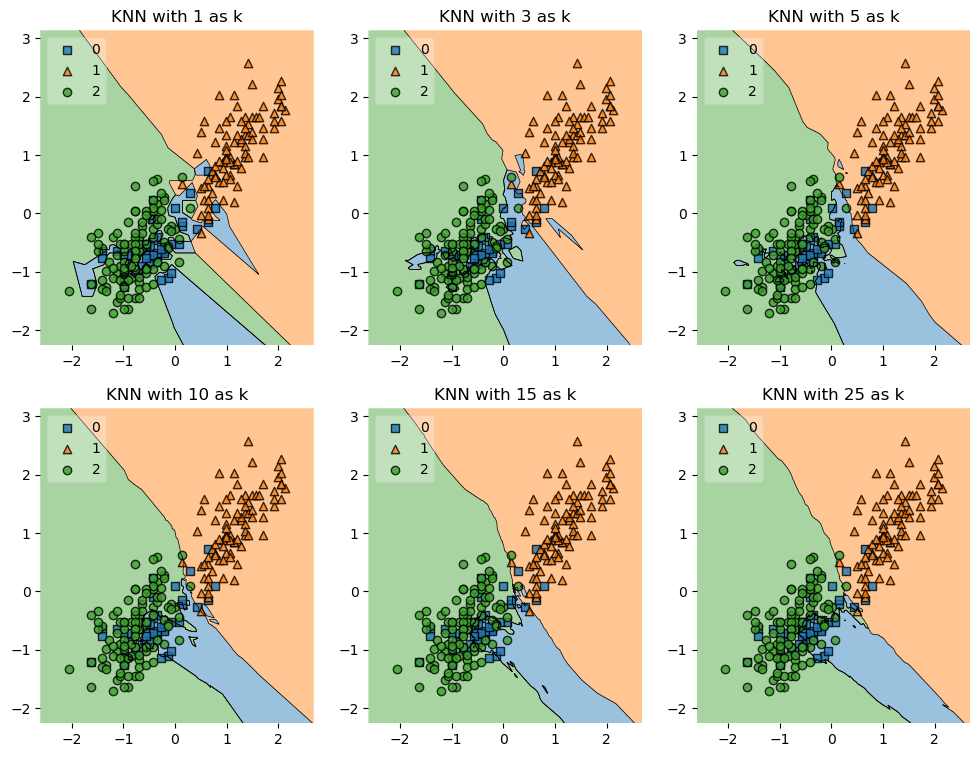

In [103]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import itertools
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,9))
gs = gridspec.GridSpec(2, 3, wspace=0.2, hspace=0.2)

for clf, lab, grd in zip(classifiers,
                         n_neightbours,
                         itertools.product([0, 1], [0, 1, 2])):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(
        X=X_train_scalered,
        y=y_train.to_numpy(),
        clf=clf,
        legend=2,
        zoom_factor=1.8,
        scatter_highlight_kwargs = {
            "s": 1/(72*2)
        }
    )
    plt.title(f"KNN with {lab} as k")

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

По скорингу лучше всего отработал KNN с 10 соседями. 
Логично взять ее как самую лучшую модель. Однако рисунок показывает, что при таких гиперпараметрах сущесвуют "островки" и проблелы внутри каждой зоны.

Сравнивая это с KNN: k=25 видим, что у последней модели значительно меньше разрырвов, а скоринг почти такой же.
Для работы модели лучше оставить ту модель, которая имеет более гладкие и четкие границы, несмотря на небольшую потерю скоринга на `test`

### Задание 2. KNN своими руками. 2,5 балла

**Задача 2.1 (2 балла)** В данном задании мы попробуем реализовать алгоритм KNN своими руками, делать мы будем KNN именно для классификации.

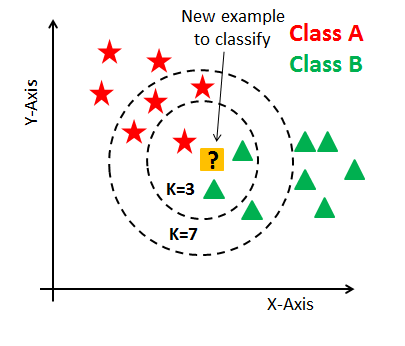

Рекомендации по реализации:
- Используйте `numpy` для представления данных в виде массивов, чтобы минимизировать преобразования.
- Избегайте циклов по всем объектам, по возможности используйте векторизированные операции.
- Обратите внимание на методы [np.linalg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) и [np.argsort()](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html), а также на класс `collections.Counter`.
- Особый плюс, если учтёте обработку возможных ошибок.

In [278]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k
        self.X = None
        self.y = None

    def fit(self, X: np.array, y: np.array):
        self.X = X
        self.y = y
        return self

    def predict(self, X):
        prediction = np.zeros(X.shape[0])
        
        for i, point in enumerate(X):
            pred = self.predict_item(point)
            prediction[i] = pred

        return prediction

    def predict_item(self, x):
        closest_dist = np.array([np.inf for _ in range(self.k)], dtype=np.float64)
        closest_idx = np.array([-1 for _ in range(self.k)])

        for i_n, neightbour in enumerate(self.X):
            d = self.count_distance(x, neightbour)
            if np.any(d < closest_dist):
                idx_first_less = np.where(closest_dist > d)[0][0]
                closest_dist = np.insert(closest_dist, idx_first_less, d)[:self.k]
                closest_idx = np.insert(closest_idx, idx_first_less, i_n)[:self.k]

        targets = self.y[closest_idx]
        t_values, t_counts = np.unique(targets, return_counts=True)
        idx_target = np.argmax(t_counts)
        return t_values[idx_target]
        

    def count_distance(self, x, y):
        square = np.square(x - y)
        return np.sqrt(np.sum(square))

In [279]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [280]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

**Задача 2.2 (0.5 балла)** Протестируйте ваш алгоритм на данных о пингвинах. Выведите лучший получившийся результат на тестовой выборке.

In [283]:
k_possible = [1, 2, 5, 15, 30, 50]
clasf = [KNN(k=nei) for nei in k_possible]

for cls in clasf:
    cls.fit(X_train_scalered, y_train.to_numpy())

print("k  | train score% | test score%")
print("-------------------------------")
for i, classi in enumerate(clasf):
    train_score = np.sum((classi.predict(X_train_scalered) == y_train.to_numpy())) / y_train.size

    test_score = np.sum((classi.predict(X_test_scalered) == y_test.to_numpy())) / y_test.size
    
    k = str(k_possible[i]) if n_neightbours[i] > 9 else f"{n_neightbours[i]} "
    print(f"{k} | {np.round(train_score * 100, 2)}        | {np.round(test_score * 100, 2)}")

k  | train score% | test score%
-------------------------------
1  | 97.07        | 71.84
3  | 87.03        | 67.96
5  | 83.26        | 78.64
15 | 82.85        | 77.67
30 | 83.26        | 79.61
50 | 79.5        | 78.64


### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [285]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

**Задача 3.2 (0.2 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Постройте матрицу корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки имеют наибольшую корреляцию с целевой переменной?

**Задача 3.3 (0.2 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные признаки методом OneHot-кодирования (`pd.get_dummies()` или `OneHotEncoder` из `sklearn`).

**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче стандартизируйте вещественные признаки в тренировочной и тестовой выборках с помощью `StandardScaler`.

Объясните, как это повлияет на интерпретацию коэффициентов линейной регрессии.

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

**Задача 3.7 (0.3 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

**Задача 3.8 (0.5 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, установив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

**Задача 3.9 (0.5 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод сильнее снижает норму коэффициентов? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.